# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Introduction to Data Science

## Lab 9: NLP, RNNs, LSTMs, ELMo 

**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas<br/>
**Authors**: Shivas Jayaram
<br/>

## Learning Objectives

By the end of this Lab, you should understand how to:
* Perform **preprocessing** operation on text
* **Tokenization** for Deep Learning models
* Build and compare various **RNN** Architectures
* Build **LSTMs** with Residual connections
* **ELMo** from sctrach using Highway Networks
* Setting up **TensorBoard** in Colab

---
You will also learn the following:
<p><strong><font color="green">🔑 Keys to DNN Kingdom 👑 : 
<ul>
<li>🔑 TF Data</li>
<li>🔑 Model using functional API</li>
<li>🔑 Custom Layer</li>
</ul>
</font></strong></p>

---


<a id="contents"></a>

## Notebook Contents

- [**Preprocessing Text Data Recap**](#prep)
    - [Review NLP Terminologies](#prep)
    - [Text processing using NLTK](#prep) 
    - [Stop words, Word Stemmer, Lemmatization](#prep)
    - [Tokenization for Deep Learning](#prep)
- [**Recurrent Neural Networks**](#rnn)   
    - [Creating various RNN model architectures](#rnn)
- [**LSTMs**](#lstms) 
  - [Creating LSTMs with Residual connections](#lstms)
- [**ELMo and Highway Networks**](#elmo)      
- [**Using TensorBaord in Colab**](#tensorboard) 

## **Setup Notebook**

**Imports**

In [21]:
# Import necessary libraries
import os
import time
import datetime
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow.python.keras import backend as K

# NLTK
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import SpaceTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import manifold

In [22]:
# download nltk's punkt sentence tokenizer
nltk.download('punkt')
# download nltk's stop words
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/u_61397728/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u_61397728/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/u_61397728/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [23]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Check what GPU you have

In [24]:
!nvidia-smi

Sat Apr 23 02:56:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    25W /  70W |  14885MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
# Utils
def display_solution(activity):
  response = requests.get(activity)
  print(response.text)  

## **Preprocessing Text Data** <div id='prep'>

#### **Review**

**Basic Definitions:**
- Natural Language Processing (NLP): The use of computers to process linguistic information into structured data and extract useful insights
- Document: A single unit of observation used in NLP, which could be as short as a word or as long as a book
- Corpus: A collection of documents from a shared context that are processed and analyzed using NLP

**Conceptual:**
- Text is structured data, but lacks the simple structure needed for quantitative analysis and ML
- Extensive preprocessing and parsing is needed to convert plain text into structured data
- How to parse a given document depends upon the specific application and the corpus being used
- Once parsed, documents can be analyzed like other quantitative datasets 


**Common NLP Tools:**
- [<font>Natural Language Toolkit</font>](https://www.nltk.org)
- [scikit-learn](https://scikit-learn.org)
- [CoreNLP](https://stanfordnlp.github.io/CoreNLP/)
- [Gensim](https://radimrehurek.com/gensim/)
- [spaCy](https://spacy.io/)
- [AllenNLP](https://allennlp.org/)
- [<font>Transformers</font>](https://huggingface.co/transformers/index.html)

**Basic Data Pipeline for NLP:**
- <font>Data ingestion from files, scraping, APIs</font>
- <font>Converting to lowercase</font>
- Treating each punctuation mark as a token (e.g., , . ! ?)
- Removing punctuation altogether
- <font>Removing stop words (very common words like the, if, to ...)</font>
- Word stemming (Stemming removes or stems the last few characters of a word)
- Lemmatization (Lemmatization considers the context and converts the word to its meaningful base form)
- <font>Parsing text using regular expressions</font>
- <font>Tokenizing / Text Vectorization</font>
- Creating n-grams
- Creating TF-IDF vectors
- <font>Creating word embeddings</font>

**Modeling Strategies**
- <strong>Creating “bag of words” models</strong>
- <strong>Creating “sequence 2 sequence” models</strong>

#### **Preprocessing using NLTK**

Consider this input text

In [26]:
input_text = """Advanced Topics in Data Science (CS109b) is the second half of a one-year introduction to data science. 
Building upon the material in Introduction to Data Science, the course introduces advanced methods for data wrangling, 
data visualization, statistical modeling, and prediction. Topics include big data, multiple deep learning architectures 
such as CNNs, RNNs, transformers, language models, autoencoders, and generative models as well as basic 
Bayesian methods, and unsupervised learning.
"""

print("Input Text:",input_text)

Input Text: Advanced Topics in Data Science (CS109b) is the second half of a one-year introduction to data science. 
Building upon the material in Introduction to Data Science, the course introduces advanced methods for data wrangling, 
data visualization, statistical modeling, and prediction. Topics include big data, multiple deep learning architectures 
such as CNNs, RNNs, transformers, language models, autoencoders, and generative models as well as basic 
Bayesian methods, and unsupervised learning.



How do we break this paragraph of text into:
- Sentences
- Words

In [27]:
# Get sentences
sentences = sent_tokenize(input_text)
print("Sentences:")
for index, sentence in enumerate(sentences):
  print(index,sentence)


# Number of sentences
print("\n Number of Sentences:", len(sentences))

Sentences:
0 Advanced Topics in Data Science (CS109b) is the second half of a one-year introduction to data science.
1 Building upon the material in Introduction to Data Science, the course introduces advanced methods for data wrangling, 
data visualization, statistical modeling, and prediction.
2 Topics include big data, multiple deep learning architectures 
such as CNNs, RNNs, transformers, language models, autoencoders, and generative models as well as basic 
Bayesian methods, and unsupervised learning.

 Number of Sentences: 3


In [28]:
# Get words
words = word_tokenize(input_text)
print("\nWords:")
print(words)

# Number of words
print("\n Number of Words:", len(words))


Words:
['Advanced', 'Topics', 'in', 'Data', 'Science', '(', 'CS109b', ')', 'is', 'the', 'second', 'half', 'of', 'a', 'one-year', 'introduction', 'to', 'data', 'science', '.', 'Building', 'upon', 'the', 'material', 'in', 'Introduction', 'to', 'Data', 'Science', ',', 'the', 'course', 'introduces', 'advanced', 'methods', 'for', 'data', 'wrangling', ',', 'data', 'visualization', ',', 'statistical', 'modeling', ',', 'and', 'prediction', '.', 'Topics', 'include', 'big', 'data', ',', 'multiple', 'deep', 'learning', 'architectures', 'such', 'as', 'CNNs', ',', 'RNNs', ',', 'transformers', ',', 'language', 'models', ',', 'autoencoders', ',', 'and', 'generative', 'models', 'as', 'well', 'as', 'basic', 'Bayesian', 'methods', ',', 'and', 'unsupervised', 'learning', '.']

 Number of Words: 84


Next we will use a Regular expression tokenizer from the NLTK library to remove any punctuation and get only words as tokens

In [29]:
# Get Word tokenizer from NLTK
tokenizer = RegexpTokenizer(r'\w+')

# Word Tokenize text
words = tokenizer.tokenize(input_text)
print("Words:")
print(words)

# Number of words
print("\n Number of Words:", len(words))

Words:
['Advanced', 'Topics', 'in', 'Data', 'Science', 'CS109b', 'is', 'the', 'second', 'half', 'of', 'a', 'one', 'year', 'introduction', 'to', 'data', 'science', 'Building', 'upon', 'the', 'material', 'in', 'Introduction', 'to', 'Data', 'Science', 'the', 'course', 'introduces', 'advanced', 'methods', 'for', 'data', 'wrangling', 'data', 'visualization', 'statistical', 'modeling', 'and', 'prediction', 'Topics', 'include', 'big', 'data', 'multiple', 'deep', 'learning', 'architectures', 'such', 'as', 'CNNs', 'RNNs', 'transformers', 'language', 'models', 'autoencoders', 'and', 'generative', 'models', 'as', 'well', 'as', 'basic', 'Bayesian', 'methods', 'and', 'unsupervised', 'learning']

 Number of Words: 69


Why are the number of tokens in this method less than before?

### Stop words

Words occuring frequently e.g: is, the etc

In [30]:
words

['Advanced',
 'Topics',
 'in',
 'Data',
 'Science',
 'CS109b',
 'is',
 'the',
 'second',
 'half',
 'of',
 'a',
 'one',
 'year',
 'introduction',
 'to',
 'data',
 'science',
 'Building',
 'upon',
 'the',
 'material',
 'in',
 'Introduction',
 'to',
 'Data',
 'Science',
 'the',
 'course',
 'introduces',
 'advanced',
 'methods',
 'for',
 'data',
 'wrangling',
 'data',
 'visualization',
 'statistical',
 'modeling',
 'and',
 'prediction',
 'Topics',
 'include',
 'big',
 'data',
 'multiple',
 'deep',
 'learning',
 'architectures',
 'such',
 'as',
 'CNNs',
 'RNNs',
 'transformers',
 'language',
 'models',
 'autoencoders',
 'and',
 'generative',
 'models',
 'as',
 'well',
 'as',
 'basic',
 'Bayesian',
 'methods',
 'and',
 'unsupervised',
 'learning']

In [31]:
stops = set(stopwords.words("english")) #stops

print("Stop words from NLTK:\n",stops) #Already defined in NLTK
print('%d stop words' % len(stops))
stops = stops.union(['I','using'])

# Find unique words that are not in the stop words
words = set([w for w in words if not w in stops])
print("Processed words:\n",words)
print('%d words' % len(words))

Stop words from NLTK:
 {'are', 'no', "don't", 'is', 'whom', 'was', 'down', 'over', 'that', "hasn't", 'don', 'this', 'aren', "she's", 'himself', 'very', 'from', 'an', 'the', "mustn't", "you're", "shan't", 'when', 'above', 'were', 'but', 'your', 'theirs', 'then', 'did', 'which', 'isn', "didn't", 'in', 'both', "couldn't", 'not', 'their', 'up', 'than', 're', 'he', 'these', "shouldn't", 'hadn', 'should', 'because', 'll', 'under', 'any', 'there', 'been', 'we', 'do', 'nor', 'ourselves', 've', 'mustn', 'o', 'about', 'doing', 'a', "it's", 'too', 'she', 'what', 'her', 'here', "mightn't", 'weren', 'shan', 'hasn', 'my', 'haven', 'more', 'on', 'below', 'who', 'i', 'wouldn', "wouldn't", 'all', 'be', 't', 'having', 'just', 'doesn', 'only', 'most', 'didn', 'his', 'to', "needn't", "haven't", 'other', 'our', 'does', 'm', "should've", 'itself', 'where', 'off', 'such', 'has', 'can', 'had', 'yourself', 'you', "isn't", 'yours', 'against', "weren't", 'after', 'if', 'themselves', 'again', "you'll", 'out', 'on

After removing stop words we hav even smaller vocabulary

### Word Stemmer

Another useful technique is word stemming, which is the process of transforming a word into its root form that allows us to map related words to the same stem. Stemming removes word endings to group together words with the same stem. For example, the words "finding" and "finds" would all be reduced to "find".

In [32]:
# Using Porter Stemmer
porter = PorterStemmer()
def tokenizer_porter(text):
     return [porter.stem(word) for word in text.split()]
tokenizer_porter('runners like running and thus they run finding find finds finder')

['runner',
 'like',
 'run',
 'and',
 'thu',
 'they',
 'run',
 'find',
 'find',
 'find',
 'finder']

### Word Lemmatization
While stemming just uses the character strings to find the common base, lemmatization looks up the part of speech of a word and converts it to a noun form. 

In [33]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def tokenizer_lemmatize(text):
     return [lemmatizer.lemmatize(word) for word in text.split()]
tokenizer_lemmatize('runners like running and thus they run runs finding find finds finder')

LookupError: 
**********************************************************************
  Resource [93momw-1.4[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('omw-1.4')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/omw-1.4[0m

  Searched in:
    - '/home/u_61397728/nltk_data'
    - '/opt/conda/envs/tensorflow/nltk_data'
    - '/opt/conda/envs/tensorflow/share/nltk_data'
    - '/opt/conda/envs/tensorflow/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


## **Tokenization for Deep Learning**

Lets review the text preprocessing steps and how we can build our data pipelines for Deep Learning models

<img src="https://storage.googleapis.com/public_colab_images/nlp/tokenization_for_dl.png" />


#### **tf.keras: Tokenizer**

In [34]:
# Initialize the Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None,
                                                filters='\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                lower=True,
                                                oov_token="UNK",
                                                split=' ',)

# Fit on text to generate token index and vocabulary
tokenizer.fit_on_texts([input_text])

# Tokenize
tokens = tokenizer.texts_to_sequences([input_text])

print(tokenizer.word_counts)
word_index = tokenizer.word_index
index_word = tokenizer.index_word
print("word_index",word_index)
vocabulary_size = len(word_index.keys())
print("Vocabulary Size:",vocabulary_size)


print("\nExample:",tokenizer.texts_to_sequences(["data science is awesome"]))
print("\nExample:",tokenizer.texts_to_sequences(["I like ice cream"]))

OrderedDict([('advanced', 2), ('topics', 2), ('in', 2), ('data', 6), ('science', 3), ('cs109b', 1), ('is', 1), ('the', 3), ('second', 1), ('half', 1), ('of', 1), ('a', 1), ('one', 1), ('year', 1), ('introduction', 2), ('to', 2), ('building', 1), ('upon', 1), ('material', 1), ('course', 1), ('introduces', 1), ('methods', 2), ('for', 1), ('wrangling', 1), ('visualization', 1), ('statistical', 1), ('modeling', 1), ('and', 3), ('prediction', 1), ('include', 1), ('big', 1), ('multiple', 1), ('deep', 1), ('learning', 2), ('architectures', 1), ('such', 1), ('as', 3), ('cnns', 1), ('rnns', 1), ('transformers', 1), ('language', 1), ('models', 2), ('autoencoders', 1), ('generative', 1), ('well', 1), ('basic', 1), ('bayesian', 1), ('unsupervised', 1)])
word_index {'UNK': 1, 'data': 2, 'science': 3, 'the': 4, 'and': 5, 'as': 6, 'advanced': 7, 'topics': 8, 'in': 9, 'introduction': 10, 'to': 11, 'methods': 12, 'learning': 13, 'models': 14, 'cs109b': 15, 'is': 16, 'second': 17, 'half': 18, 'of': 19, 

Encoding the tokens as different vector representations

In [35]:
test_documents = ["data science is awesome", "i like ice cream"]

vectors = tokenizer.texts_to_matrix(test_documents, mode='binary')
print("binary vectors:", vectors)

vectors = tokenizer.texts_to_matrix(test_documents, mode='count')
print("count vectors:", vectors)

vectors = tokenizer.texts_to_matrix(test_documents, mode='tfidf')
print("tfidf vectors:", vectors)

binary vectors: [[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
count vectors: [[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
tfidf vectors: [[0.         0.69314718 0.40546511 0.40546511 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.40546511 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         

#### **tf.keras: TextVectorization Layer**

In [36]:
# Set maximum number of words in vocab
max_tokens = 45

# Initialize Text Vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens+2, # 0 is reserved for padding, 1 is reserved for UNK
    output_mode="int"
)

# Fit on text to generate token index and vocabulary
text_vectorizer.adapt([input_text])

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)

# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))

print("vocabulary:",len(vocabulary),vocabulary)
print("word_index:",word_index)

print("\nExample:",text_vectorizer("data science is awesome"))
print("\nExample:",text_vectorizer("I like ice cream"))

Vocabulary Size: 47
vocabulary: 47 ['', '[UNK]', 'data', 'the', 'science', 'as', 'and', 'topics', 'to', 'models', 'methods', 'learning', 'introduction', 'in', 'advanced', 'wrangling', 'well', 'visualization', 'upon', 'unsupervised', 'transformers', 'such', 'statistical', 'second', 'rnns', 'prediction', 'oneyear', 'of', 'multiple', 'modeling', 'material', 'language', 'is', 'introduces', 'include', 'half', 'generative', 'for', 'deep', 'cs109b', 'course', 'cnns', 'building', 'big', 'bayesian', 'basic', 'autoencoders']
word_index: {'': 0, '[UNK]': 1, 'data': 2, 'the': 3, 'science': 4, 'as': 5, 'and': 6, 'topics': 7, 'to': 8, 'models': 9, 'methods': 10, 'learning': 11, 'introduction': 12, 'in': 13, 'advanced': 14, 'wrangling': 15, 'well': 16, 'visualization': 17, 'upon': 18, 'unsupervised': 19, 'transformers': 20, 'such': 21, 'statistical': 22, 'second': 23, 'rnns': 24, 'prediction': 25, 'oneyear': 26, 'of': 27, 'multiple': 28, 'modeling': 29, 'material': 30, 'language': 31, 'is': 32, 'intr

Encoding the tokens as different vector representations

Binary 1-gram bag-of-words

In [37]:
# Initialize Text Vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens+2,
    output_mode="multi_hot"
)
# Fit on text to generate token index and vocabulary
text_vectorizer.adapt([input_text])

print("Vocabulary:",text_vectorizer.get_vocabulary())
print("\nExample:",text_vectorizer("data science is awesome"))
print("\nExample:",text_vectorizer("I like ice cream"))

Vocabulary: ['[UNK]', 'data', 'the', 'science', 'as', 'and', 'topics', 'to', 'models', 'methods', 'learning', 'introduction', 'in', 'advanced', 'wrangling', 'well', 'visualization', 'upon', 'unsupervised', 'transformers', 'such', 'statistical', 'second', 'rnns', 'prediction', 'oneyear', 'of', 'multiple', 'modeling', 'material', 'language', 'is', 'introduces', 'include', 'half', 'generative', 'for', 'deep', 'cs109b', 'course', 'cnns', 'building', 'big', 'bayesian', 'basic', 'autoencoders', 'architectures']

Example: tf.Tensor(
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(47,), dtype=float32)

Example: tf.Tensor(
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(47,), dtype=float32)


Bigram bag-of-words

In [38]:
# Initialize Text Vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(
    ngrams=2,
    output_mode="count"
)
# Fit on text to generate token index and vocabulary
text_vectorizer.adapt([input_text])

print("Vocabulary:",text_vectorizer.get_vocabulary())
print("\nExample:",text_vectorizer("data science is awesome"))
print("\nExample:",text_vectorizer("I like ice cream"))

Vocabulary: ['[UNK]', 'data', 'the', 'science', 'data science', 'as', 'and', 'topics', 'to data', 'to', 'models', 'methods', 'learning', 'introduction to', 'introduction', 'in', 'advanced', 'wrangling data', 'wrangling', 'well as', 'well', 'visualization statistical', 'visualization', 'upon the', 'upon', 'unsupervised learning', 'unsupervised', 'transformers language', 'transformers', 'topics include', 'topics in', 'the second', 'the material', 'the course', 'such as', 'such', 'statistical modeling', 'statistical', 'second half', 'second', 'science the', 'science cs109b', 'science building', 'rnns transformers', 'rnns', 'prediction topics', 'prediction', 'oneyear introduction', 'oneyear', 'of a', 'of', 'multiple deep', 'multiple', 'models autoencoders', 'models as', 'modeling and', 'modeling', 'methods for', 'methods and', 'material in', 'material', 'learning architectures', 'language models', 'language', 'is the', 'is', 'introduces advanced', 'introduces', 'include big', 'include', 'i

## **Recurrent Neural Networks**

This section is to get you familiar with different RNN architectures. We will be working with a Named Entity Recognition (NER) dataset.

### **Load the data**

The dataset contains all the sentences, with each word tagged. </br>
The tags can be:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

Extract each sentence and transform it into an adequate format.  Use **df.fillna(method='ffill', inplace=True)** to fill the NaN values and extract the values easily.</br>

In [39]:
# Load data
data = pd.read_csv('https://storage.googleapis.com/dataset_store/nlp/ner_dataset.csv', 
                 encoding= 'unicode_escape', 
                 usecols=['Sentence #','Word','Tag'])

# Take a quick look at the dataset
print("Shape:",data.shape)
data.head()

Shape: (1048575, 3)


,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


### **Build Data Pipelines**

**Clean Data**



The sentence is marked only at the first word with NaNs for the rest of the cells. We need to fill them with sentence number

In [40]:
# We fill Nan values using the previous value. 
# This way we can separate each sentence.
data.fillna(method='ffill', inplace=True)

# Remove "Sentence: " from the sentence column
data['Sentence #'] = data['Sentence #'].str.replace('Sentence: ','').astype(int)

# Set the index as the sentence number. Then we filter each sentence, joininig the text
data.set_index('Sentence #', inplace=True)

print("Shape:",data.shape)
data.head()

Shape: (1048575, 2)


,Word,Tag
Sentence #,,
1,Thousands,O
1,of,O
1,demonstrators,O
1,have,O
1,marched,O


['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


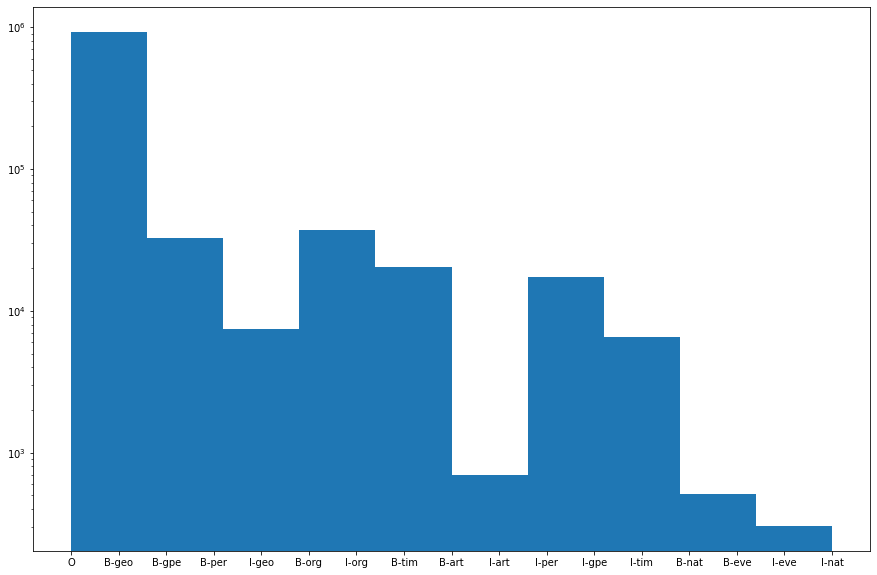

In [41]:
# Take a quick look at the different tags
print(data["Tag"].unique())
plt.figure(figsize=(15,10))
plt.hist(data["Tag"], log=True)
plt.show()

Let us look at the first sentence

In [42]:
# Print first sentence
sentence = data.loc[1]
for index, row in sentence.iterrows():
  print(row["Word"],"->",row["Tag"])

Thousands -> O
of -> O
demonstrators -> O
have -> O
marched -> O
through -> O
London -> B-geo
to -> O
protest -> O
the -> O
war -> O
in -> O
Iraq -> B-geo
and -> O
demand -> O
the -> O
withdrawal -> O
of -> O
British -> B-gpe
troops -> O
from -> O
that -> O
country -> O
. -> O


Select sentences with more than 15 and less than 30 words.

In [43]:
# Filter the dataframe by sequence length
index, length = np.unique(data.index, return_counts=True)

b1 = length>15
b2 = length<30
b = np.logical_and(b1, b2)

index = index[b]
length = length[b]

data = data.loc[index]

print("length",length)
# Take a quick look at the dataset
print("Shape:",data.shape)
data.head()

length [24 25 24 ... 29 20 24]
Shape: (653765, 2)


,Word,Tag
Sentence #,,
1,Thousands,O
1,of,O
1,demonstrators,O
1,have,O
1,marched,O


**Tokenize**

In [44]:
# Transform the tags into labels using LabelEnconder
le = LabelEncoder()
data['Tag'] = le.fit_transform(data.Tag)

# Initialize tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None,
                                                filters='\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                lower=True,
                                                split=' ',)
# Fit on entire text
tokenizer.fit_on_texts(data.Word.values)

# Transform to tokens
tokens = tokenizer.texts_to_sequences(data.Word.values)

# Remove empty elements
b = np.array([token!=[] for token in tokens])
data = data.iloc[b,:]
tokens = np.array(tokens, dtype=object)[b]

data.Word = tokens
data.Word=data.Word.map(lambda x: x[0])


print("Shape:",data.shape)
data.head()

Shape: (600549, 2)


,Word,Tag
Sentence #,,
1,248,16
1,3,16
1,859,16
1,14,16
1,1501,16


In [45]:
# Print first sentence
test_sentence = data.loc[1]
for index, row in test_sentence.iterrows():
  print(row["Word"],"->",row["Tag"])

248 -> 16
3 -> 16
859 -> 16
14 -> 16
1501 -> 16
238 -> 16
472 -> 2
5 -> 16
490 -> 16
1 -> 16
124 -> 16
2 -> 16
57 -> 2
6 -> 16
590 -> 16
1 -> 16
812 -> 16
3 -> 16
178 -> 3
85 -> 16
21 -> 16
12 -> 16
50 -> 16


In [46]:
# Prepare training data by building the sentences from each word 
IDs = data.index.unique()

sentences = []
tags = []
Ns = []
for i in IDs: # For each id for the sentence
    sel = data.loc[i] # We extract the respective data
    if len(sel.shape)<2: # If the data is not formatted properly
        continue # Ommit that id
        
    sentence = sel.Word.values # A sentence is a list of tokens
    tag = sel['Tag'].values # The tags correspond to each token
    
    sentences.append(sentence)  # We store the sentences in a list
    tags.append(tag)            # We do the same with the tags
    Ns.append(sentence.shape[0])# And store the length of the sentence
    
# We transform everything into np arrays    
Ns = np.array(Ns)
sentences = np.array(sentences, dtype=object)
tags = np.array(tags, dtype=object)    

# To speed up calculations, we filter by sequence length
# We do not care much of long sentences.
b1 = Ns>15
b2 = Ns<30
b = np.logical_and(b1, b2)

# We filter the training set
Ns = Ns[b]
sentences = sentences[b]
tags = tags[b]

# For simplicity, we create a padded array beforehand
sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences, padding='post')
tags = tf.keras.preprocessing.sequence.pad_sequences(tags, padding='post')

print("Shape:",sentences.shape)

Shape: (26521, 28)


In [47]:
# View some data
for idx in range(3):
  print("Input",len(sentences[idx]), sentences[idx])
  print("Output",len(tags[idx]),tags[idx])
  print("*************")

Input 28 [ 248    3  859   14 1501  238  472    5  490    1  124    2   57    6
  590    1  812    3  178   85   21   12   50    0    0    0    0    0]
Output 28 [16 16 16 16 16 16  2 16 16 16 16 16  2 16 16 16 16 16  3 16 16 16 16  0
  0  0  0  0]
*************
Input 28 [    1   490   532    10     1  1928     3     1  1079   460     3   403
     7   487   831   139     2     1   125  2429  8837  1453     3 13911
     0     0     0     0]
Output 28 [16 16 16 16 16 16 16 16 16 16 16  2 16 16  5 13 16 16 16  3 16 16 16  2
  0  0  0  0]
*************
Input 28 [   1  139   11 1749   84  403    7 3158    2    1   57  609    6    1
  718 2100    3  528  178   85    2   12   50    0    0    0    0    0]
Output 28 [16 16 16 16 16  3 16 16 16 16  2 16 16 16 16 16 16 16  3 16 16 16 16  0
  0  0  0  0]
*************


We split data into train and validation by randomly selecting 20% as the validation set.

In [48]:
# Split data
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(sentences, tags, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 21216
validate_x count: 5305


In [49]:
# Number of unique labels
num_classes = le.classes_.shape[0] 
print("Number of classes:", num_classes)

vocabulary_size = len(tokenizer.word_counts)
print("Vocabulary Size:",vocabulary_size)

Number of classes: 17
Vocabulary Size: 22817


### **Single Layer RNN**

**Build Model**

Define a model, which will be many to many.

* The first layer should be Embedding, with _mask_zero_ set to True. This will propagate the mask in the network.
* Then, a SimpleRNN layer. We set here the number of hidden units. Remember to return the sequence of hidden states.
* We will define a Dense layer, with size set as the number of classes and activation softmax. 

In [50]:
def build_single_rnn(num_classes,vocab_size,embedding_dim):
  # Model input
  model_input = tf.keras.Input(shape=(None,), name='sentence_input')

  # Embedding
  hidden = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, 
                        name='word_embedding', mask_zero=True)(model_input)

  # Forward RNN layer
  hidden = tf.keras.layers.SimpleRNN(units=embedding_dim, return_sequences=True)(hidden)

  # Output Layer
  output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = tf.keras.Model(inputs=model_input, outputs=output, name="single_rnn")

  return model

**Train**

In [51]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 20
embedding_dim = 8

# Free up memory
K.clear_session()

# Build the model
model = build_single_rnn(num_classes,vocabulary_size, embedding_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_x,train_y,
        validation_data= (validate_x,validate_y),
        batch_size=1024,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "single_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sentence_input (InputLayer)  [(None, None)]           0         
                                                                 
 word_embedding (Embedding)  (None, None, 8)           182544    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 8)           136       
                                                                 
 dense (Dense)               (None, None, 17)          153       
                                                                 
Total params: 182,833
Trainable params: 182,833
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
21/21 [==============================] - 27s 53ms/step - loss: 2.0921 - accuracy: 0.2112 - val_loss: 2.0448 - val_accuracy: 0.4036
Epoch 2/20
21/21 [=================

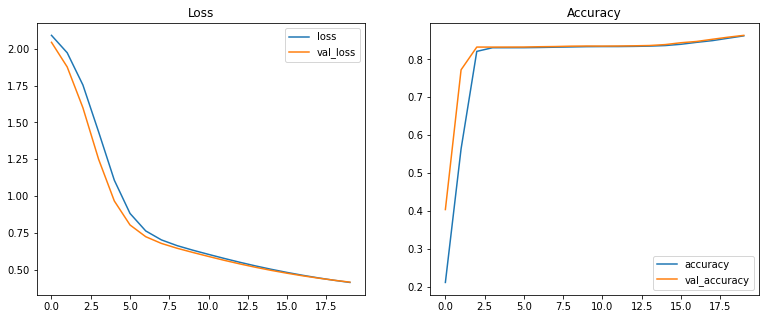

In [52]:
# Plot training results
fig = plt.figure(figsize=(20,5))
axs = fig.add_subplot(1,3,1)
axs.set_title('Loss')
# Plot all metrics
for metric in ["loss","val_loss"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

axs = fig.add_subplot(1,3,2)
axs.set_title('Accuracy')
# Plot all metrics
for metric in ["accuracy","val_accuracy"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

plt.show()

### **Various Models Architectures 🎊🎉**

### **<font color='red'>Activity</font> 🎊🎉** 


**Create the following architectures:**

Create a function to build different RNN architectures. For simplicity, use the SimpleRNN.

* Create a single-layer RNN network 
* Create a k-layer RNN network, where k=[2,3]. 
* Create a bidirectional single-layer RNN.  
* Create a bidirectional k-layer RNN, where k=[2,3]. 

In [53]:
# Create a function for all model options
def build_model(num_classes,vocab_size,embedding_dim,rnn_layers,bidir):
  # Model input
  model_input = tf.keras.Input(shape=(None,), name='sentence_input')

  # Embedding
  hidden = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, 
                        name='word_embedding', mask_zero=True)(model_input)

  # Create RNNs
  hidden_forward = []
  hidden_backward = []
  for k in range(rnn_layers):
    # Forward RNN layer
    hidden = tf.keras.layers.SimpleRNN(units=embedding_dim, return_sequences=True)(hidden)
    hidden_forward.append(hidden)

    # Backward RNN layer
    if bidir:
      hidden_b = tf.keras.layers.SimpleRNN(units=embedding_dim, return_sequences=True, go_backwards=True)(hidden)
      hidden_backward.append(hidden_b)
  
  if bidir:
      hidden = tf.keras.layers.concatenate(hidden_forward+hidden_backward)
  else:
      if rnn_layers==1:
          hidden = hidden_forward[0]
      else:
          hidden = tf.keras.layers.concatenate(hidden_forward)

  # Output Layer
  output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = tf.keras.Model(inputs=model_input, outputs=output, name='_'.join([str(embedding_dim), str(rnn_layer),str(bidir)]))

  return model

**Solution**

In [54]:
display_solution("https://storage.googleapis.com/public-code-snippets/cs109b_lab9_activity1.txt")

# Create a function for all model options
def build_model(num_classes,vocab_size,embedding_dim,rnn_layers,bidir):
  # Model input
  model_input = tf.keras.Input(shape=(None,), name='sentence_input')

  # Embedding
  hidden = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, 
                        name='word_embedding', mask_zero=True)(model_input)

  # Create RNNs
  hidden_forward = []
  hidden_backward = []
  for k in range(rnn_layers):
    # Forward RNN layer
    hidden = tf.keras.layers.SimpleRNN(units=embedding_dim, return_sequences=True)(hidden)
    hidden_forward.append(hidden)

    # Backward RNN layer
    if bidir:
      hidden_b = tf.keras.layers.SimpleRNN(units=embedding_dim, return_sequences=True, go_backwards=True)(hidden)
      hidden_backward.append(hidden_b)
  
  if bidir:
      hidden = tf.keras.layers.concatenate(hidden_forward+hidden_backward)
  else:
      if rnn_layers==1:
          hidden = hidden_forward[0]
      else:
          hidden 

Run each model experiment with the following training parameters

In [55]:
############################
# Training Params
############################
learning_rate=0.001
epochs = 20
embedding_dim = [32,64] # [8,32,64]
num_rnn_layers = [1,2] # [2,3]

all_training_results = []

for e_dim in embedding_dim:
  for rnn_layer in num_rnn_layers:
    for bidir in [False,True]:
      # Free up memory
      K.clear_session()

      # Build the model
      model = build_model(num_classes,vocabulary_size, e_dim, rnn_layer, bidir)

      # Print the model architecture
      print(model.name)
      #print(model.summary())

      # Optimizer
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      # Loss
      loss = tf.keras.losses.sparse_categorical_crossentropy

      # Compile
      model.compile(loss=loss,
                        optimizer=optimizer,
                        metrics=['accuracy'])

      # Train model
      start_time = time.time()
      training_results = model.fit(
              train_x,train_y,
              validation_data= (validate_x,validate_y),
              batch_size=1024,
              epochs=epochs, 
              verbose=0)
      all_training_results.append(training_results)
      execution_time = (time.time() - start_time)/60.0
      print("Training execution time (mins)",execution_time)

32_1_False
Training execution time (mins) 0.25669445594151813
32_1_True
Training execution time (mins) 0.49709102710088093
32_2_False
Training execution time (mins) 0.48726726373036705
32_2_True
Training execution time (mins) 0.9529780507087707
64_1_False
Training execution time (mins) 0.3028216560681661
64_1_True
Training execution time (mins) 0.5916741132736206
64_2_False
Training execution time (mins) 0.5885754704475403
64_2_True
Training execution time (mins) 1.1231298128763834


**Evaluate Models**

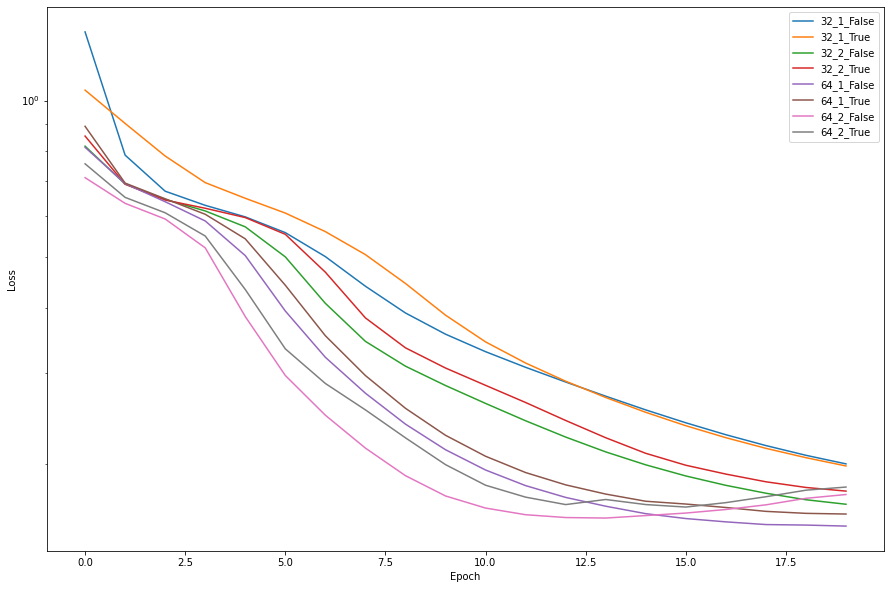

In [56]:
# plot the results
plt.figure(figsize=(15,10))
for training_results in all_training_results:
    plt.plot(training_results.history['val_loss'], label=training_results.model.name)
plt.legend(loc=0)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

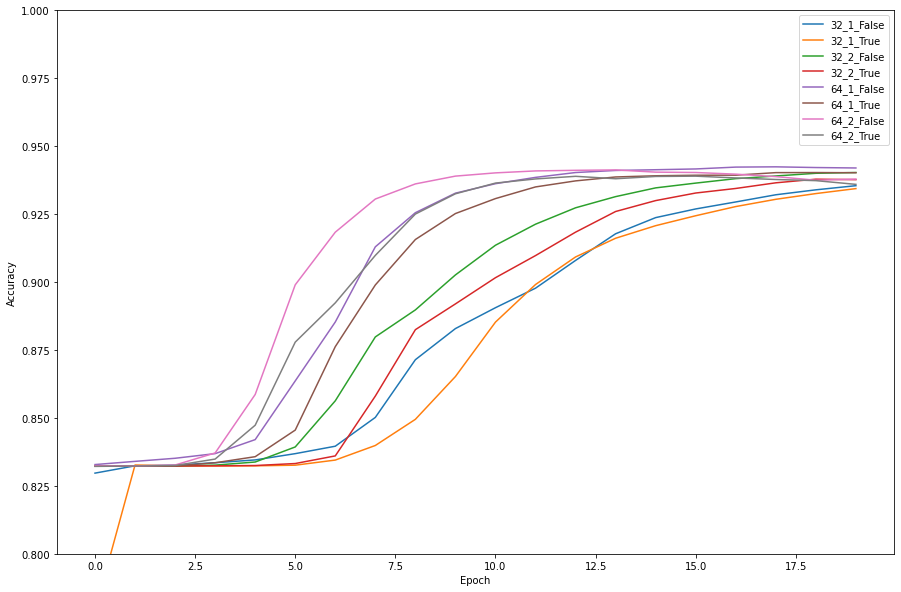

In [57]:
plt.figure(figsize=(15,10))
for training_results in all_training_results:
    plt.plot(training_results.history['val_accuracy'], label=training_results.model.name)
plt.legend(loc=0)
plt.ylim(0.8,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Which model is performing well?

## **LSTMs**

### **Load the data**

In [58]:
# Read the data
file_path = "https://storage.googleapis.com/cs109b/nlp/imdb.csv"
data = pd.read_csv(file_path, encoding='latin1')
print("Shape:",data.shape)
data.head()

Shape: (10000, 2)


,text,polarity
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


In [59]:
# Get data x and y
data_x = data["text"].values
data_y = data["polarity"].values

# Number of unique labels
num_classes = len(np.unique(data_y))
print("Number of classes:", num_classes)

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

Number of classes: 2
data_x: 10000
data_y: 10000
data_x: ["first think another Disney movie, might good, it's kids movie. watch it, can't help enjoy it. ages love movie. first saw movie 10 8 years later still love it! Danny Glover superb could play part better. Christopher Lloyd hilarious perfect part. Tony Danza believable Mel Clark. can't help, enjoy movie! give 10/10!"
 'Put aside Dr. House repeat missed, Desperate Housewives (new) watch one. don\'t know exactly plagued movie. never thought I\'d say this, want 15 minutes fame back.<br /><br />Script, Direction, can\'t say. recognized stable actors (the usual suspects), thought Herbert Marshall class addition sat good cheesy flick. Boy, wrong. Dullsville.<br /><br />My favorite parts: "office girl" makes 029 keypunch puts cards 087 sorter. LOL @ "the computer". I\'d like someone identify next device - 477 ? It\'s even dinosaur\'s time.<br /><br />And dinosaurs don\'t much time waste.'
 'big fan Stephen King\'s work, film made even gr

### **Build Data Pipelines**

**Split Data** 

We split data into train and validation by randomly selecting 20% as the test set.

In [60]:
# Split data
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent, stratify=data_y)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 8000
validate_x count: 2000


**Text Tokenization**

In [61]:
# Define a tokenizer with vocabulary size of 10,000 that filters all special characters and 
# converts the characters to lowercase
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000,
                                                  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                  lower=True,
                                                  split=' ',
                                                  char_level=True,)

# Fit the tokenizer on the comments column of the train set
tokenizer.fit_on_texts(train_x)

# Convert the text to tokens
train_token_x = tokenizer.texts_to_sequences(train_x)
validate_token_x = tokenizer.texts_to_sequences(validate_x)

print("train_x len :",len(train_token_x))
print("train_x:",train_token_x[:5])
print("validate_token_x len :",len(validate_token_x))
print("validate_token_x:",validate_token_x[:5])

vocabulary_size = tokenizer.num_words
print("Vocabulary Size:",vocabulary_size)

train_x len : 8000
train_x: [[16, 9, 3, 8, 16, 1, 10, 3, 2, 20, 1, 11, 2, 6, 17, 3, 5, 2, 1, 10, 9, 9, 25, 3, 8, 16, 1, 3, 8, 5, 2, 7, 2, 6, 5, 3, 8, 16, 24, 1, 22, 4, 5, 12, 14, 2, 11, 1, 8, 9, 5, 9, 7, 3, 9, 15, 6, 1, 19, 2, 5, 5, 3, 2, 1, 17, 4, 16, 2, 1, 14, 2, 4, 7, 11, 1, 35, 4, 8, 11, 1, 21, 4, 3, 7, 10, 18, 1, 9, 19, 23, 3, 9, 15, 6, 1, 10, 9, 9, 25, 3, 8, 16, 1, 6, 18, 8, 9, 17, 6, 3, 6, 1, 4, 8, 18, 5, 14, 3, 8, 16, 1, 21, 3, 10, 13, 34, 24, 1, 16, 7, 2, 5, 12, 14, 2, 8, 1, 13, 9, 10, 1, 16, 9, 5, 1, 8, 4, 25, 2, 11, 1, 3, 5, 20, 1, 8, 2, 23, 2, 7, 1, 21, 4, 8, 1, 13, 9, 10, 24, 1, 12, 4, 8, 8, 9, 5, 1, 7, 2, 6, 3, 6, 5, 1, 6, 2, 2, 3, 8, 16, 1, 4, 5, 5, 7, 4, 12, 5, 3, 23, 2, 1, 22, 9, 13, 4, 8, 1, 5, 4, 25, 3, 8, 16, 1, 12, 10, 9, 5, 14, 2, 6, 20, 1, 18, 2, 6, 24, 1, 13, 4, 18, 1, 17, 2, 7, 23, 2, 7, 5, 2, 11, 24, 1, 5, 14, 2, 13, 2, 1, 3, 11, 2, 4, 10, 1, 12, 2, 8, 5, 7, 4, 10, 1, 12, 9, 7, 2, 1, 13, 9, 23, 3, 2, 24, 1, 14, 2, 10, 17, 6, 1, 13, 4, 25, 2, 1, 21, 3, 10, 13, 

**Create TF Datasets**

<p>🛑🛑🛑 &nbsp;&nbsp;<strong><font color="green">🔑 Keys to DNN Kingdom 👑 : TF Data</font></strong>&nbsp;&nbsp;🛑🛑🛑</p>

In [62]:
batch_size = 64
train_shuffle_buffer_size = len(train_token_x)
validation_shuffle_buffer_size = len(validate_token_x)

def pad(x, y):
  return x.to_tensor(default_value=0, shape=[None, None]), y

# Use tensorflow ragged constants to get the ragged version of data
train_processed_x = tf.ragged.constant(train_token_x)
validate_processed_x = tf.ragged.constant(validate_token_x)
train_processed_y = tf.ragged.constant(train_y)
validate_processed_y = tf.ragged.constant(validate_y)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_processed_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_processed_x, validate_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(pad, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)
#train_data = train_data.cache()

##################
# Validation data
##################
# Apply all data processing logic
#validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.map(pad, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
validation_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [63]:
# View some data from tf dataset
for input,output in train_data.take(1):
  print(input.shape,output.shape)
  
  print("Input:",input[0])
  print("Output:",output[0])
  print("****************")
  print("Input:",input[1])
  print("Output:",output[1])

(64, 3771) (64,)
Input: tf.Tensor([ 9 21  5 ...  0  0  0], shape=(3771,), dtype=int32)
Output: tf.Tensor(1, shape=(), dtype=int64)
****************
Input: tf.Tensor([30 33  4 ...  0  0  0], shape=(3771,), dtype=int32)
Output: tf.Tensor(1, shape=(), dtype=int64)


### **Simple Model**

Now define a simple single layer LSTM model

In [64]:
############################
# Training Params
############################
learning_rate = 1e-2
epochs = 20
embedding_dim = 128
hidden_size = 12

**Build Model**

<p>🛑🛑🛑 &nbsp;&nbsp;<strong><font color="green">🔑 Keys to DNN Kingdom 👑 : Model using functional API</font></strong>&nbsp;&nbsp;🛑🛑🛑</p>

In [65]:
def build_simple_lstm_model(num_classes,vocab_size,embedding_dim,hidden_size):
  # Model input
  model_input = tf.keras.Input(shape=(None,), name='sentence_input')

  # Embedding
  embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, 
                        name='word_embedding', mask_zero=True)(model_input)

  # LSTM layer
  hidden1 = tf.keras.layers.LSTM(units=hidden_size, return_sequences=False)(embedding)

  hidden = tf.keras.layers.Dense(units=hidden_size, activation='relu')(hidden1)

  # Output Layer
  output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = tf.keras.Model(inputs=model_input, outputs=output)

  return model

**Train**

In [66]:
# Free up memory
tf.keras.backend.clear_session()

# Build the model
model = build_simple_lstm_model(num_classes,vocabulary_size, embedding_dim, hidden_size)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data= validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sentence_input (InputLayer)  [(None, None)]           0         
                                                                 
 word_embedding (Embedding)  (None, None, 128)         1280128   
                                                                 
 lstm (LSTM)                 (None, 12)                6768      
                                                                 
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 2)                 26        
                                                                 
Total params: 1,287,078
Trainable params: 1,287,078
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20


2022-04-23 03:02:54.862932: E tensorflow/stream_executor/cuda/cuda_dnn.cc:373] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-04-23 03:02:54.863003: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at cudnn_rnn_ops.cc:1556 : UNKNOWN: Fail to find the dnn implementation.


UnknownError: Graph execution error:

Detected at node 'cond/CudnnRNNV3' defined at (most recent call last):
    File "/opt/conda/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/opt/conda/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/opt/conda/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 369, in dispatch_shell
      await result
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_133/3732254497.py", line 22, in <cell line: 22>
      training_results = model.fit(
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/layers/recurrent.py", line 679, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/layers/recurrent_v2.py", line 1255, in call
      runtime) = lstm_with_backend_selection(**normal_lstm_kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/layers/recurrent_v2.py", line 1651, in lstm_with_backend_selection
      _function_register(defun_gpu_lstm, **params)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/layers/recurrent_v2.py", line 1783, in _function_register
      concrete_func = func.get_concrete_function(*args, **kwargs)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/layers/recurrent_v2.py", line 1618, in gpu_lstm_with_fallback
      return tf.cond(
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/layers/recurrent_v2.py", line 1592, in cudnn_lstm_fn
      return gpu_lstm(
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/layers/recurrent_v2.py", line 1480, in gpu_lstm
      outputs, h, c, _, _ = tf.raw_ops.CudnnRNNV3(
Node: 'cond/CudnnRNNV3'
Fail to find the dnn implementation.
	 [[{{node cond/CudnnRNNV3}}]]
	 [[model/lstm/PartitionedCall]] [Op:__inference_train_function_67366]

In [ ]:
# Plot training results
fig = plt.figure(figsize=(20,5))
axs = fig.add_subplot(1,3,1)
axs.set_title('Loss')
# Plot all metrics
for metric in ["loss","val_loss"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

axs = fig.add_subplot(1,3,2)
axs.set_title('Accuracy')
# Plot all metrics
for metric in ["accuracy","val_accuracy"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

plt.show()

**Evaluate**

In [ ]:
# Predict on the test set
pred = model.predict(validation_data)
pred = pred.argmax(axis=1)

# Print the classification report comparing the true labels and the predicted ones
print(classification_report(validate_processed_y, pred))

### **Model with Residual Connections 🎊🎉**

Now define LSTM model with residual connections. 

From the google [Translate paper](https://arxiv.org/abs/1609.08144), we can see that skip connections enable us to train deeper recurrent networks.

For that, add skips connections between different LSTMs layers.

**Build Model**

<p>🛑🛑🛑 &nbsp;&nbsp;<strong><font color="green">🔑 Keys to DNN Kingdom 👑 : Model using functional API</font></strong>&nbsp;&nbsp;🛑🛑🛑</p>

**<font color='red'>Activity</font> 🎊🎉** 

In [ ]:
def build_lstm_residual_connections_model(num_classes,vocab_size,embedding_dim,hidden_size):
  # Model input
  model_input = tf.keras.Input(shape=(None,), name='sentence_input')

  # Embedding
  # Add a embedding layer with dimension tokenizer.num_words+1 and embedding size.
  # Set mask_zero as true 
  embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, 
                        name='word_embedding', mask_zero=True)(model_input)

  # Add an LSTM layer with hidden size and return the sequences
  hidden1 = tf.keras.layers.LSTM(units=hidden_size, return_sequences=True)(embedding)
  # Create residual connection
  #residual1 = hidden1 + embedding # This will not work the dimension of embedding cannot be added to hidden1
  embedding_projections = tf.keras.layers.Dense(units=hidden_size, activation='relu')
  residual1 = hidden1 + embedding_projections(embedding)

  # Add another LSTM layer with hidden size and return the sequences
  hidden2 = tf.keras.layers.LSTM(units=hidden_size, return_sequences=True)(residual1)
  # Create a residual connection
  residual2 = hidden2 + hidden1

  # Add another LSTM layer with hidden size and return the sequences
  hidden3 = tf.keras.layers.LSTM(units=hidden_size, return_sequences=True)(residual2)
  # Create a residual connection
  residual3 = hidden3 + hidden2

  # Add another LSTM layer with hidden size and return the sequences
  hidden4 = tf.keras.layers.LSTM(units=hidden_size, return_sequences=True)(residual3)

  # Concatenate all hidden states
  hidden = tf.keras.layers.Concatenate(axis=2)([hidden1, hidden2, hidden3, hidden4])

  # Use last LSTM layer with hidden size and return sequences False
  final = tf.keras.layers.LSTM(units=hidden_size, return_sequences=False)(hidden)

  # Output Layer
  output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(final)

  # Create model
  model = tf.keras.Model(inputs=model_input, outputs=output)

  return model

**Solution**

In [ ]:
display_solution("https://storage.googleapis.com/public-code-snippets/cs109b_lab9_activity2.txt")

**Train**

In [ ]:
############################
# Training Params
############################
learning_rate = 1e-2
epochs = 3 # 20
embedding_dim = 128
hidden_size = 12

# Free up memory
tf.keras.backend.clear_session()

# Build the model
model = build_lstm_residual_connections_model(num_classes,vocabulary_size, embedding_dim, hidden_size)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data= validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

In [ ]:
# Plot training results
fig = plt.figure(figsize=(20,5))
axs = fig.add_subplot(1,3,1)
axs.set_title('Loss')
# Plot all metrics
for metric in ["loss","val_loss"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

axs = fig.add_subplot(1,3,2)
axs.set_title('Accuracy')
# Plot all metrics
for metric in ["accuracy","val_accuracy"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

plt.show()

**Evaluate**

In [ ]:
# Predict on the test set
pred = model.predict(validation_data)
pred = pred.argmax(axis=1)

# Print the classification report comparing the true labels and the predicted ones
print(classification_report(validate_processed_y, pred))

## **ELMo and Highway Networks**

**Steps:**

* Load the IMDB dataset from keras datasets
* Split the dataset into train and test data and labels
* Define the input and output of the ELMo model
* Generate TF Datasets 
* Define a class HighwayLayer that inherits from tf.keras.layers.Layer to implement the highway network layer
* Define an ELMo model with the custom highway layer
* Compile and train the ELMo model
* Plot the trace plot of the model history
* For a sentence in the test dataset, extract both the word embeddings and the contextual embeddings of the sentence by passing it through the trained ELMo model

### **Load the data**


Load the IMDB dataset

In [68]:
# Use the helper code given to load the IMDB dataset with the following parameters
n_words = 2000
skip= 100
data_train, data_validation = tf.keras.datasets.imdb.load_data(num_words=n_words,skip_top=skip, maxlen=200 )

In [69]:
print("data_train input shape:",data_train[0].shape)
print("data_train output shape:",data_train[1].shape)
print("data_validation input shape:",data_validation[0].shape)
print("data_validation outout shape:",data_validation[1].shape)

# View a training samples
for i in range(5):
  print("Length:",len(data_train[0][i]))
  print(data_train[0][i])
  print(data_train[1][i])

data_train input shape: (14244,)
data_train output shape: (14244,)
data_validation input shape: (14669,)
data_validation outout shape: (14669,)
Length: 189
[2, 194, 1153, 194, 2, 2, 228, 2, 2, 1463, 2, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 207, 110, 2, 2, 2, 2, 188, 2, 2, 2, 2, 2, 249, 126, 2, 2, 114, 2, 2, 1523, 2, 647, 2, 116, 2, 2, 2, 2, 229, 2, 340, 1322, 2, 118, 2, 2, 130, 2, 2, 2, 1002, 2, 2, 2, 952, 2, 2, 2, 455, 2, 2, 2, 2, 1543, 1905, 398, 2, 1649, 2, 2, 2, 163, 2, 2, 2, 2, 1153, 2, 194, 775, 2, 2, 2, 349, 2, 148, 605, 2, 2, 2, 123, 125, 2, 2, 2, 2, 349, 165, 2, 2, 2, 2, 228, 2, 2, 2, 1157, 2, 299, 120, 2, 120, 174, 2, 220, 175, 136, 2, 2, 2, 228, 2, 2, 2, 656, 245, 2, 2, 2, 2, 131, 152, 491, 2, 2, 2, 2, 1212, 2, 2, 2, 371, 2, 2, 625, 2, 1382, 2, 2, 168, 145, 2, 2, 1690, 2, 2, 2, 1355, 2, 2, 2, 2, 154, 462, 2, 2, 2, 285, 2, 145, 2]
0
Length: 141
[2, 2, 2, 2, 2, 2, 2, 2, 249, 108, 2, 2, 2, 2, 2, 369, 2, 2, 149, 2, 2, 112, 2, 2, 311, 2, 2, 2, 2, 2

Our input sentences are ragged and we will need to handle that in our data pipeleines to feed to the model for training

In [70]:
### Helper code to fix the mapping of the imdb word index
index = tf.keras.datasets.imdb.get_word_index()

# we need to add 3 from the indices because 0 is 'padding', 1 is 'start of sequence' and 2 is 'unknown'
inv_index = { j+3:i for i,j in index.items()}
inv_index[0] = ""
inv_index[1] = "<s>"
inv_index[2] = "UNK"

In [71]:
# Display actual text
review = [inv_index[token] for token in data_train[0][0]]
print("review:"," ".join(review))

review: UNK big hair big UNK UNK music UNK UNK giant UNK UNK these UNK UNK words UNK best describe UNK terrible UNK UNK love cheesy horror movies UNK i've seen UNK UNK UNK UNK got UNK UNK UNK UNK UNK worst ever UNK UNK plot UNK UNK thin UNK ridiculous UNK acting UNK UNK UNK UNK script UNK completely laughable UNK best UNK UNK end UNK UNK UNK cop UNK UNK UNK worked UNK UNK UNK killer UNK UNK UNK UNK damn terribly written UNK clothes UNK UNK UNK funny UNK UNK UNK UNK hair UNK big lots UNK UNK UNK men UNK those cut UNK UNK UNK show off UNK UNK UNK UNK men actually UNK UNK UNK UNK music UNK UNK UNK trash UNK plays over UNK over again UNK almost every scene UNK UNK UNK music UNK UNK UNK taking away UNK UNK UNK UNK still doesn't close UNK UNK UNK UNK aside UNK UNK UNK truly UNK UNK whose UNK charm UNK UNK look back UNK UNK disaster UNK UNK UNK 80's UNK UNK UNK UNK old laugh UNK UNK UNK everything UNK back UNK


### **Build Data Pipelines**

* The data is already preprocessed. 
* We define the input and target words.

* We will predict the next word based on the input.


**Generate Training Data**

For the training the model we need sentences as inputs and outputs. We will train the models in a semi-supervised way. So the input will be all the words of the sentence, except the last one. The output is all the words of the sentence, except the first one

In [72]:
# Define the input and output of the network for both, the train and test sets
# The input is the all the words of the sentence, except the last one
# The output is all the words of the sentence, except the first one

train_x  = [i[:-1] for i in data_train[0]]
train_y = [i[1:] for i in data_train[0]]

validation_x  = [i[:-1] for i in data_validation[0]]
validation_y = [i[1:] for i in data_validation[0]]

In [73]:
# View a few samples
for i in range(5):
  print("")
  print("Length:",len(train_x[i]),train_x[i])
  print("Length:",len(train_y[i]),train_y[i])


Length: 188 [2, 194, 1153, 194, 2, 2, 228, 2, 2, 1463, 2, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 207, 110, 2, 2, 2, 2, 188, 2, 2, 2, 2, 2, 249, 126, 2, 2, 114, 2, 2, 1523, 2, 647, 2, 116, 2, 2, 2, 2, 229, 2, 340, 1322, 2, 118, 2, 2, 130, 2, 2, 2, 1002, 2, 2, 2, 952, 2, 2, 2, 455, 2, 2, 2, 2, 1543, 1905, 398, 2, 1649, 2, 2, 2, 163, 2, 2, 2, 2, 1153, 2, 194, 775, 2, 2, 2, 349, 2, 148, 605, 2, 2, 2, 123, 125, 2, 2, 2, 2, 349, 165, 2, 2, 2, 2, 228, 2, 2, 2, 1157, 2, 299, 120, 2, 120, 174, 2, 220, 175, 136, 2, 2, 2, 228, 2, 2, 2, 656, 245, 2, 2, 2, 2, 131, 152, 491, 2, 2, 2, 2, 1212, 2, 2, 2, 371, 2, 2, 625, 2, 1382, 2, 2, 168, 145, 2, 2, 1690, 2, 2, 2, 1355, 2, 2, 2, 2, 154, 462, 2, 2, 2, 285, 2, 145]
Length: 188 [194, 1153, 194, 2, 2, 228, 2, 2, 1463, 2, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 207, 110, 2, 2, 2, 2, 188, 2, 2, 2, 2, 2, 249, 126, 2, 2, 114, 2, 2, 1523, 2, 647, 2, 116, 2, 2, 2, 2, 229, 2, 340, 1322, 2, 118, 2, 2, 

**Create TF Datasets**

<p>🛑🛑🛑 &nbsp;&nbsp;<strong><font color="green">🔑 Keys to DNN Kingdom 👑 : TF Data</font></strong>&nbsp;&nbsp;🛑🛑🛑</p>

In [86]:
batch_size = 512
train_shuffle_buffer_size = len(train_x)
validation_shuffle_buffer_size = len(validate_x)

def pad(x, y):
  return (x.to_tensor(default_value=0, shape=[None, None]), y.to_tensor(default_value=0, shape=[None, None]))

# Use tensorflow ragged constants to get the ragged version of data
train_processed_x = tf.ragged.constant(train_x)
validation_processed_x = tf.ragged.constant(validation_x)
train_processed_y = tf.ragged.constant(train_y)
validation_processed_y = tf.ragged.constant(validation_y)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_processed_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validation_processed_x, validation_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(pad, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.map(pad, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>
validation_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>


In [87]:
# View some data from tf dataset
for input,output in train_data.take(1):
  print(input.shape,output.shape)
  
  print("Input:",input[0])
  print("Output:",output[0])
  # print("****************")
  # print("Input:",input[1])
  # print("Output:",output[1])

(512, 198) (512, 198)
Input: tf.Tensor(
[   2    2    2    2    2    2 1930  503    2    2  372    2    2 1930
    2    2    2  328    2  549    2  433  377    2  503  681 1025    2
    2  681    2    2    2    2    2    2    2  131    2    2    2    2
    2    2  567  503    2    2    2  236  155  372  842  159    2    2
    2    2    2    2    2  232    2    2  567    2    2  772    2 1101
    2  567  934    2    2  203    2    2  992  232  269    2 1108    2
  255    2    2    2    2    2  481    2    2    2    2    2    2    2
    2    2  428  493    2    2  311  743    2    2    2  137    2  379
  117    2  428  372    2    2    2    2    2    2  499  695    2    2
    2    2    2    2    2  255    2    2    2    2    2    2  152  264
    2 1425  879    2    2    2  216    2    2  475    2    2  181  372
    2    2    2  879    2    2  503    2    2    2    2    2    2    2
    2  194    2    2    2    2    2    2    2  104  879    2    2    2
    2  349    2  595    2    0    0  

### **ELMo Model 🎊🎉**

Now Build the ELMo model to extract embeddings

**Custom Highway Network Layer**


<p>🛑🛑🛑 &nbsp;&nbsp;<strong><font color="green">🔑 Keys to DNN Kingdom 👑 : Custom Layer</font></strong>&nbsp;&nbsp;🛑🛑🛑</p>



You should include a highway connection between the layers of the LSTM. Keras doesn't have it by default.

Remember that a highway network is written as:
$$x = z \odot T +r \odot C$$
Where $r$ is the output of the previous layer, $z$ the result of a dense layer applied to $r$, $T$ and $C$ the Transform gate and Carry gate, respectively.

For simplicity, we assume that $C$ = $1-T$. Then, the highway network is:
\begin{align}
x &= z \odot T +r \odot (1-T) \\
&= z \odot T -r \odot T+ r \\
&= (z -r)\odot T + r 
\end{align}
$$ $$
To create a the highway network, we create the $T$ vector to multiplicate each value of the input.


Note that we add self.supports_masking = True to support masking. This attribute ensures that the layer will propagate its input mask to its outputs; masking in Keras is by default False. 

**<font color='red'>Activity</font> 🎊🎉** 

In [88]:
# Define a class that builds the custom layer for the highway network
# This will implement the equation presented above

class HighwayLayer(tf.keras.layers.Layer):
    def __init__(self):
      super(HighwayLayer, self).__init__()
      self.supports_masking = ___
    
    # The __call__() method of your layer will automatically run build the first time it is called
    def build(self, input_shape):
      # Create the state of the layer (weights)
      # Define a tf.Variable using tf.random_normal_initializer with mean=0.0 and stddev=0.05, shape=[1,input_shape[-1]
      # Make sure to set tge trainable=True for the tf.Variable
      self.T = ___     

    def call(self, z, r):
      # compute the highway network output as show above
      return ___


**Solution**

In [89]:
##display_solution("https://storage.googleapis.com/public-code-snippets/cs109b_lab9_activity3.txt")

**Build Model**

<p>🛑🛑🛑 &nbsp;&nbsp;<strong><font color="green">🔑 Keys to DNN Kingdom 👑 : Model using functional API</font></strong>&nbsp;&nbsp;🛑🛑🛑</p>

In [90]:
def build_model(vocab_size,embedding_dim,hidden_size):
  # Model input
  model_input = tf.keras.Input(shape=(None,), name='sentence_input')

  # Embedding
  embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, 
                        name='embedding', mask_zero=True)(model_input)

  # LSTM layer
  r = tf.keras.layers.LSTM(units=hidden_size, return_sequences=True, name="r")(embedding)
  z = tf.keras.layers.Dense(units=hidden_size,name="z")(r)

  # Highway
  h1_hw = HighwayLayer()(z,r)

  h2 = tf.keras.layers.LSTM(units=hidden_size, return_sequences=True, name="h2")(h1_hw)

  # Output Layer
  output = tf.keras.layers.Dense(units=vocab_size+1, activation='softmax', name='softmax_layer')(h2)

  # Create model
  model = tf.keras.Model(inputs=model_input, outputs=output)

  # Create Toy ELMo model
  toy_ELMo = tf.keras.Model(inputs=model_input, outputs=[embedding,h2], name='Toy_ELMo')

  return model, toy_ELMo

**Train**

In [83]:
############################
# Training Params
############################
learning_rate = 5e-2
epochs = 10
embedding_dim = 32
hidden_size = 10
vocabulary_size = n_words

# Free up memory
tf.keras.backend.clear_session()

# Build the model
model, toy_ELMo = build_model(vocabulary_size, embedding_dim, hidden_size)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data= validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Plot Training Metrics

In [ ]:
# Plot training results
fig = plt.figure(figsize=(20,5))
axs = fig.add_subplot(1,3,1)
axs.set_title('Loss')
# Plot all metrics
for metric in ["loss","val_loss"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

axs = fig.add_subplot(1,3,2)
axs.set_title('Accuracy')
# Plot all metrics
for metric in ["accuracy","val_accuracy"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

plt.show()

### Extract embedding of a sentence

We can extract the word embeddings. For an arbitrary sentence, we extract the word embedding.

In [84]:
# View some data from tf dataset
for batch in validation_data.take(1):
  input, output = batch
  print(input.shape,output.shape)

(512, 198) (512, 198)


In [85]:
# Pass the input through the toy elmo model
model_outputs = toy_ELMo(input)
print("model_outputs",len(model_outputs))

# Unpack the outputs
embedding,h2 = model_outputs

print("embedding:",embedding.shape)
print(embedding[0])
print("h2:",h2.shape)
print(h2[0])

NameError: name 'toy_ELMo' is not defined

## **Using TensorBoard in Colab**

Load the extension

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

Download some data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_validation, y_validation) = fashion_mnist.load_data()
x_train, x_validation = x_train / 255.0, x_validation / 255.0

Creat a simple model

In [ ]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

Start TensorBoard

In [ ]:
%tensorboard --logdir logs

Train the model using the Tensorboard checkpoint callback

In [ ]:
############################
# Training Params
############################
learning_rate=0.001
epochs = 10
hidden_size = 10

# Free up memory
tf.keras.backend.clear_session()

# Build the model
model = create_model()

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Callbacks
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks = [tensorboard_callback]

# Train model
start_time = time.time()
training_results = model.fit(
        x=x_train,
        y=y_train,
        validation_data= (x_validation, y_validation),
        epochs=epochs,
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)